In [0]:
from __future__ import print_function
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.RandomErasing(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

In [26]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plane   dog  deer  deer


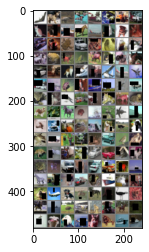

In [29]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [33]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,728
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,864
       BatchNorm2d-4           [-1, 64, 28, 28]             128
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
        BasicBlock-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
       BasicBlock-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 14, 14]          73,728
      BatchNorm2d-14          [-1, 128,

In [34]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [36]:
from torch.optim.lr_scheduler import StepLR

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


loss=1.3128658533096313 batch_id=390 Accuracy=45.09: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.4159, Accuracy: 5075/10000 (51%)

EPOCH: 1


loss=0.8910708427429199 batch_id=390 Accuracy=63.72: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9001, Accuracy: 6814/10000 (68%)

EPOCH: 2


loss=0.6864941716194153 batch_id=390 Accuracy=71.58: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7291, Accuracy: 7435/10000 (74%)

EPOCH: 3


loss=0.6743451356887817 batch_id=390 Accuracy=75.60: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6297, Accuracy: 7797/10000 (78%)

EPOCH: 4


loss=0.7297579050064087 batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7172, Accuracy: 7650/10000 (76%)

EPOCH: 5


loss=0.6257880330085754 batch_id=390 Accuracy=80.94: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7282, Accuracy: 7516/10000 (75%)

EPOCH: 6


loss=0.47556549310684204 batch_id=390 Accuracy=82.80: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6161, Accuracy: 7984/10000 (80%)

EPOCH: 7


loss=0.3969596028327942 batch_id=390 Accuracy=84.33: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5444, Accuracy: 8195/10000 (82%)

EPOCH: 8


loss=0.49508029222488403 batch_id=390 Accuracy=86.00: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7410, Accuracy: 7808/10000 (78%)

EPOCH: 9


loss=0.2619898319244385 batch_id=390 Accuracy=87.14: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5733, Accuracy: 8081/10000 (81%)

EPOCH: 10


loss=0.4373173713684082 batch_id=390 Accuracy=88.16: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7050, Accuracy: 7927/10000 (79%)

EPOCH: 11


loss=0.2611427307128906 batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6469, Accuracy: 8097/10000 (81%)

EPOCH: 12


loss=0.3053247928619385 batch_id=390 Accuracy=90.02: 100%|██████████| 391/391 [00:39<00:00, 10.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5425, Accuracy: 8373/10000 (84%)

EPOCH: 13


loss=0.23626084625720978 batch_id=390 Accuracy=90.66: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5020, Accuracy: 8447/10000 (84%)

EPOCH: 14


loss=0.32496652007102966 batch_id=390 Accuracy=91.50: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7336, Accuracy: 8065/10000 (81%)

EPOCH: 15


loss=0.3124541640281677 batch_id=390 Accuracy=92.03: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6791, Accuracy: 8178/10000 (82%)

EPOCH: 16


loss=0.24870741367340088 batch_id=390 Accuracy=92.66: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5826, Accuracy: 8384/10000 (84%)

EPOCH: 17


loss=0.13365361094474792 batch_id=390 Accuracy=93.06: 100%|██████████| 391/391 [00:38<00:00, 10.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5349, Accuracy: 8471/10000 (85%)

EPOCH: 18


loss=0.21462512016296387 batch_id=390 Accuracy=93.64: 100%|██████████| 391/391 [00:38<00:00, 10.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 8240/10000 (82%)

EPOCH: 19


loss=0.23661062121391296 batch_id=390 Accuracy=93.97: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7339, Accuracy: 8152/10000 (82%)

EPOCH: 20


loss=0.15100625157356262 batch_id=390 Accuracy=94.28: 100%|██████████| 391/391 [00:38<00:00, 10.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5907, Accuracy: 8445/10000 (84%)

EPOCH: 21


loss=0.09007011353969574 batch_id=390 Accuracy=94.56: 100%|██████████| 391/391 [00:38<00:00, 10.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6086, Accuracy: 8447/10000 (84%)

EPOCH: 22


loss=0.11447111517190933 batch_id=390 Accuracy=94.75: 100%|██████████| 391/391 [00:38<00:00, 10.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7600, Accuracy: 8201/10000 (82%)

EPOCH: 23


loss=0.10656806081533432 batch_id=390 Accuracy=95.11: 100%|██████████| 391/391 [00:38<00:00, 10.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5678, Accuracy: 8498/10000 (85%)

EPOCH: 24


loss=0.20423340797424316 batch_id=390 Accuracy=95.48: 100%|██████████| 391/391 [00:37<00:00, 10.34it/s]



Test set: Average loss: 0.6082, Accuracy: 8470/10000 (85%)



GroundTruth:   frog   car  ship  frog


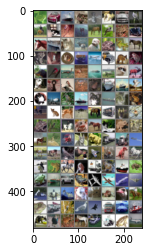

In [37]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Text(0.5, 1.0, 'Test Accuracy')

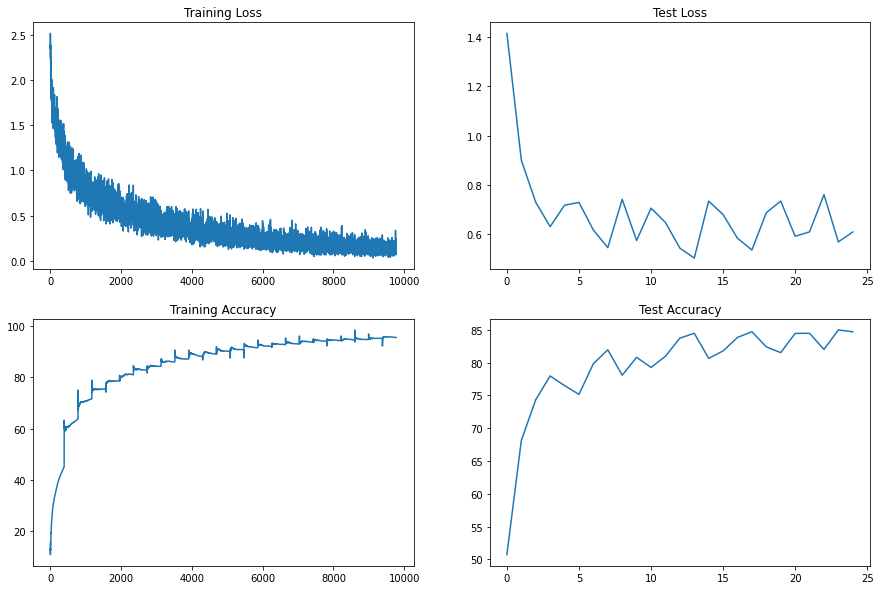

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
class GradCAM:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output):
              self.fmap_pool[key] = output.detach()

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out):
              self.grad_pool[key] = grad_out[0].detach()

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def GRADCAM(images, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(model.device)
  # set up grad cam
  gcam = GradCAM(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(model.device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids

def PLOT(gcam_layers, images, labels, target_layers, class_names, image_size, predicted, unnormalize):
    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(32,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f"pred={class_names[predicted[j][0]]}\n[actual={class_names[labels[j]]}]", fontsize=14)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')
          
        
        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')
        
        plt.axis('off')
    plt.show()